In [7]:
from pathlib import Path
from dataclasses import dataclass
from typing import Any

from IPython.display import display # type: ignore
import ipywidgets as widgets # type: ignore

import torch
import supervision as sv
from transformers import AutoProcessor, GroundingDinoProcessor, AutoModelForZeroShotObjectDetection # type: ignore
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


In [8]:
torch.cuda.empty_cache()
print(f"Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"Reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

Allocated: 0.00 GB
Reserved: 0.00 GB


In [9]:
data_path = Path.home() / "src/data"
mobs_path = data_path / "mobs1/640"
image_files = sorted(list(mobs_path.iterdir()))

classes = '''
chicken
cow
creeper
enderman
pig
player
sheep
skeleton
spider
villager
zombie
'''.split()
classes_orig = sorted(classes)
classes_minecraft = [f"minecraft {x}" for x in classes_orig]

@dataclass
class Config:
    classes: list[str]

    # Post-processing parameters
    threshold: float
    text_threshold: float


In [10]:
class ImageDirViewer:
    def __init__(self, image_dir: str | Path, glob_pat: str = "*.png"):
        self.image_dir = image_dir
        self.image_files = sorted(Path(image_dir).glob(glob_pat))
        self.current_file = None
        self.current_index = 0
    
    def view_image_cb(self, index: int):
        self.current_index = index
        self.current_file = self.image_files[index]
        
        img = Image.open(self.current_file)
        print(f"dir={self.image_dir} n_images={len(self.image_files)}")
        print(f"index={index} file={self.current_file.name}")
        display(img)
    
    def show_widget(self):
        slider = widgets.IntSlider(
            value=0,
            min=0,
            max=len(self.image_files) - 1,
            description='Image:',
            continuous_update=False
        )
        widgets.interact(self.view_image_cb, index=slider)


In [11]:
viewer = ImageDirViewer(mobs_path)
viewer.show_widget()

interactive(children=(IntSlider(value=0, continuous_update=False, description='Image:', max=46), Output()), _d…

In [16]:
# model_id = "IDEA-Research/grounding-dino-tiny"
model_id = "IDEA-Research/grounding-dino-base"
processor: GroundingDinoProcessor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

In [17]:
def detect(image: Image, cfg: Config) -> dict[Any, Any]:
    print(f"detect cfg: {cfg}")

    inputs = processor(images=image, text=cfg.classes, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)

    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        threshold=cfg.threshold,
        text_threshold=cfg.text_threshold,
        target_sizes=[image.size[::-1]]
    )

    result: dict[Any, Any] = results[0]
    for box, score, labels in zip(result["boxes"], result["scores"], result["text_labels"]):
        box = [round(x, 2) for x in box.tolist()]
        print(f"Detected {labels} with confidence {round(score.item(), 3)} at location {box}")

    return result

def fix_grounding_dino_result(result: dict) -> tuple[dict, dict]:
    """Work around bug in grounding dino transformer. result["labels"] are supposed to be ints."""
    # Create label mapping
    unique_labels = list(set(result["text_labels"]))
    label2id = {label: idx for idx, label in enumerate(unique_labels)}
    id2label = {idx: label for label, idx in label2id.items()}
    
    # Fix result
    result_fixed = result.copy()
    result_fixed["labels"] = torch.tensor(
        [label2id[label] for label in result["text_labels"]], 
        device=result["boxes"].device
    )
    
    return result_fixed, id2label

def infer(image_file: str | Path, cfg: Config):
    image_file = Path(image_file)
    image = Image.open(image_file).convert("RGB")
    result = detect(image, cfg)

    result_fixed, id2label = fix_grounding_dino_result(result)
    detections = sv.Detections.from_transformers(result_fixed, id2label=id2label)
    # Create annotators
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    # Create labels
    labels = [
        f"{label}: {score:.2f}"
        for label, score in zip(result["text_labels"], result["scores"])
    ]

    # Annotate
    annotated_image = box_annotator.annotate(scene=image.copy(), detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
    return annotated_image

detect cfg: Config(classes=['minecraft chicken', 'minecraft cow', 'minecraft creeper', 'minecraft enderman', 'minecraft pig', 'minecraft player', 'minecraft sheep', 'minecraft skeleton', 'minecraft spider', 'minecraft villager', 'minecraft zombie'], threshold=0.3, text_threshold=0.3)


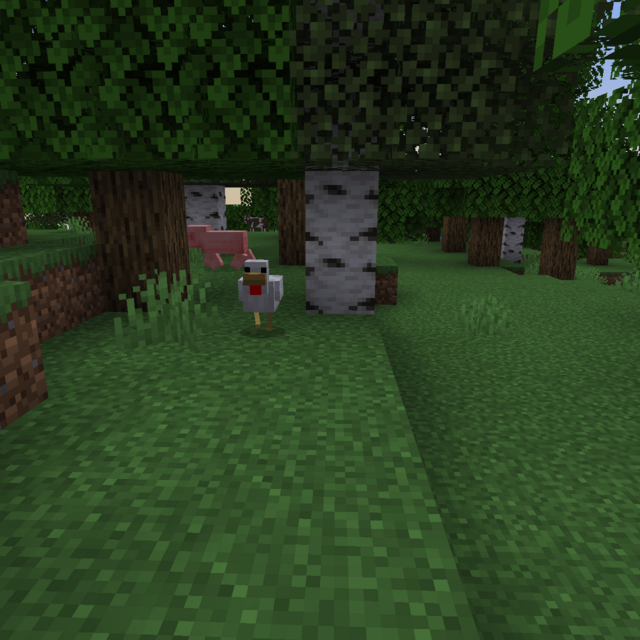

In [18]:
fname = mobs_path / '06092b21-2024-10-20_22.22.09.png'
image = infer(fname, Config(classes_minecraft, 0.3, 0.3))
display(image)

In [19]:
class InferViewer:
    def __init__(self, cfg: Config, image_dir: str | Path, glob_pat: str = "*.png"):
        self.image_dir = image_dir
        self.image_files = sorted(Path(image_dir).glob(glob_pat))
        self.cfg = cfg
        self.current_file = None
        self.current_index = 0
    
    def view_image_cb(self, index: int):
        self.current_index = index
        self.current_file = self.image_files[index]
        
        image = infer(self.current_file, self.cfg)
        print(f"dir={self.image_dir} n_images={len(self.image_files)}")
        print(f"index={index} file={self.current_file.name}")
        display(image)
    
    def show_widget(self):
        slider = widgets.IntSlider(
            value=0,
            min=0,
            max=len(self.image_files) - 1,
            description='Image:',
            continuous_update=False
        )
        widgets.interact(self.view_image_cb, index=slider)


In [ ]:
viewer = InferViewer(Config(classes_minecraft, 0.3, 0.5), mobs_path)
viewer.show_widget()

interactive(children=(IntSlider(value=0, continuous_update=False, description='Image:', max=46), Output()), _d…